In [14]:
import numpy as np
import scipy as sp
import sys
import matplotlib.pyplot as plt
from scipy.integrate import simpson
import random
from random import randint
import scipy.constants as const
from scipy.signal import find_peaks


In [15]:

E = 1.5 #meV
epsilon = 5.99 # meV
sigma = 2 # Angstrom
rmax = 30 # Angstrom
h = 0.015 # spacing
N = rmax/h #number of points
r = np.arange(h, rmax, h)
l = 9

print(N)


# - Masses:
#Kr mass = 83.798 u
#H mass = 1.008 u
# 1 u = 931.494 MeV
m_Kr= 83.798 #u
m_H = 1.008 #u
m = 931.494 * m_Kr * m_H /(m_Kr+ m_H) #MeV/c^2      reduced mass

# - Costants:
h_bar_Js = const.hbar #hbar in Js
h_bar = h_bar_Js / (1.6e-19) # hbar in eVs
c=const.c

# - Useful quantities:
a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m) #1e-3 for conversion meV, eV -> meV - 1e-10 for conversion m -> Å
b = (4*epsilon * (sigma**12) /(25*a))**(0.1)

print(a)

2000.0
2.1041471061733663


In [16]:
# Potential
def V(r,s):
    V = 4*epsilon * ((s/r)**12 - (s/r)**6) #meV
    return V


# Numerov
def Numerov(E,h,l,r,s):
    y = np.zeros(len(r))
    k = np.zeros(len(r))
    # Initialization of values
    
    for j in range(2, len(r)):
        k[j] = (1/a)*(E-V(r[j],s))-l*(l+1)/(r[j])**2
    
  
    for j in range(0, len(r)-1):
        
        if r[j]<=sigma/2:
            y[j]=np.exp(-(b/r[j])**5)
        else:
            y[j+1] = (-y[j-1]*(1+h**2/12*k[j-1])+2*y[j]*(1-(5*h**2)/12*k[j]))/((1+h**2/12*k[j+1]))

    return y


# Normalization
def normalize(psi,x):
  """ Normalization of the wavefunction calculing the integral of the wavefunction"""
  # Step 1: Compute the modulus squared of the wave function
  mod_squared_psi = np.abs(psi)**2

  # Step 2: Integrate the modulus squared over all space
  integral_value = simpson(mod_squared_psi, x)

  # Step 3: Calculate the normalization constant
  normalization_constant = 1 / np.sqrt(np.abs(integral_value))

  # Step 4: Apply the normalization constant
  normalized_psi = [y*normalization_constant for y in psi]
  return normalized_psi





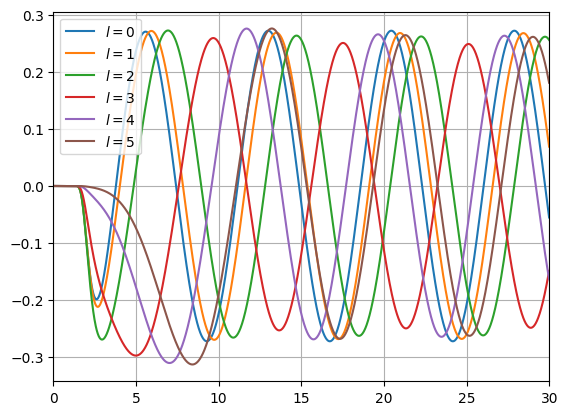

In [17]:
fig, ax = plt.subplots()
ax.set_xlim(0,30)
for j in range(6):
    psi = Numerov(E,h,j,r,sigma)
    PSI = normalize(psi,r)
    ax.plot(r, PSI, label=rf'$l={j}$')   
plt.legend(loc='best')
plt.grid()
plt.show()

In [18]:
# Define Bessel functions

def j_1(r):
    return np.sin(r)/(r**2) - np.cos(r)/r
    
def n_1(r):
    return -np.cos(r)/(r**2) - np.sin(r)/r
    
    
def j_0(r):
    return np.sin(r)/r
    
def n_0(r):
    return -np.cos(r)/r
    
'''
 define the recursion relations
 input: l - order of bessel
        sl - l-th bessel evaluated at r
        sl1 - (l-1)-th bessel evaluated at r
        r - point to evaluate the bessel
 output: l+1 bessel, evaluated at r
'''
def recursive_bessel(l,sl,sl1,r):
    return ((2*l+1)/(r))*sl - sl1

'''   
 define a function to create a matrix of Bessel functions
 input: l - maximum order of bessel, 
        r - array of r values
 output: two matrices of Bessels (one of first kind, one of second kind) of order 0,...,l-1 evaluated on an array r
''' 
def Bessel_l(l,r):
    bess_matj = np.zeros((l,len(r)))
    bess_matn = np.zeros((l,len(r)))

    for j in range(len(r)):
        bess_matj[0][j] = j_0(r[j])
        bess_matn[0][j] = n_0(r[j])
        bess_matj[1][j] = j_1(r[j])
        bess_matn[1][j] = n_1(r[j])
        
    for w in range(2,l):
        for j in range(len(r)):
            bess_matj[w][j] = recursive_bessel(w-1,bess_matj[w-1][j], bess_matj[w-2][j],r[j])
            bess_matn[w][j] = recursive_bessel(w-1,bess_matn[w-1][j], bess_matn[w-2][j],r[j])
            
    return bess_matj, bess_matn
  

In [19]:
'''
define phase shift function
input: r1,r2 - two points to evaluate the phase shift
       r - array of r values for numerov
       l - angular momentum
       En - energy
       lmax - maximum order of bessel
       sigma - parameter of the potential
output: phase shift delta_l as defined in class
'''
def Phase_shift(r1,r2,r,l,En,lmax,sigma):
    jj, nn = Bessel_l(lmax,np.sqrt(1/a*En)*r)
    psi = Numerov(En,h,l,r,sigma)
    u = normalize(psi,r)
    kk=(u[r1]*r[r2])/(u[r2]*r[r1])
    tan_delta_l=(kk*jj[l][r2]-jj[l][r1])/(kk*nn[l][r2]-nn[l][r1])
    delta_l=np.arctan(tan_delta_l)
    return delta_l

# a simpler phase shift function if i only want tan delta l
def Phase_shift_tg(r1,r2,r,l,En,lmax,sigma):
    jj, nn = Bessel_l(lmax,np.sqrt(1/a*En)*r)
    psi = Numerov(En,h,l,r,sigma)
    u = normalize(psi,r)
    kk=(u[r1]*r[r2])/(u[r2]*r[r1])
    tan_delta_l=(kk*jj[l][r2]-jj[l][r1])/(kk*nn[l][r2]-nn[l][r1])
    return tan_delta_l




In [20]:
#Define E and l vectors
Evec=np.logspace(-1,1.1, num=60)
#Evec[0] = Evec[1]/10
lvec=[z for z in range(0,l,1)]
rep=1
lmax=l

SHIFTS = np.zeros((len(lvec),len(Evec)))

r1 =randint(len(r)-100,len(r)-1)   
r2 =randint(len(r)-300,len(r)-200)   
print(r1,r2)    

for i in range(len(lvec)):
    for j in range(len(Evec)):
            SHIFTS[i][j]=Phase_shift_tg(r1,r2,r,lvec[i],Evec[j],lmax,sigma)



1983 1772


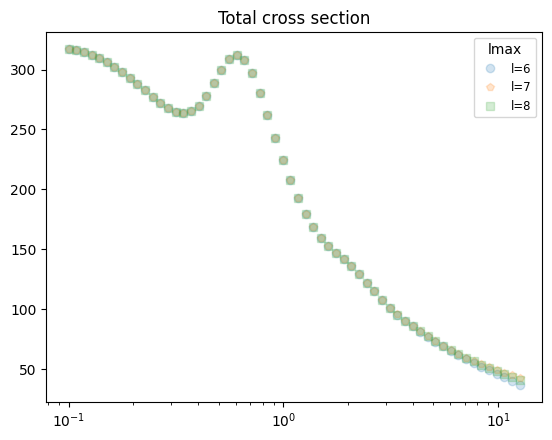

In [21]:
def totalcross(l,shifts):
    cross = np.zeros(len(Evec))
    for i in range(len(Evec)):
        a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m) #1e-3 for conversion meV, eV -> meV - 1e-10 for conversion m -> Å
        factor= 4 * a * np.pi/Evec[i]
        sum = 0
        for k in range(l):
            tan_l = shifts[k][i]
            sin_squared = tan_l**2/(1+tan_l**2)
            sum+=(2*k+1)*sin_squared
        
        cross[i]=(factor*sum)
   
    return cross

def totalcross1(l,shifts):
    cross = np.zeros(len(Evec))
    for i in range(len(Evec)):
        a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m) #1e-3 for conversion meV, eV -> meV - 1e-10 for conversion m -> Å
        factor= 4 * a * np.pi/Evec[i]
        sum = 0
        for k in range(l):
            sin_squared = shifts[k][i]**2/(1+shifts[k][i]**2)
            sum+=(2*k+1)*sin_squared
        
        cross[i]=(factor*sum)
   
    return cross

cross6 = totalcross1(7,SHIFTS)
cross7 = totalcross1(8,SHIFTS)
cross8 = totalcross1(9,SHIFTS)

fig, ax = plt.subplots()
ax.set_title(r'Total cross section')
ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim(0.9e2, 500)
#ax.set_xlim(0.1, 5)
ax.plot(Evec, cross6, 'o', alpha=.2)  
ax.plot(Evec, cross8, 'p', alpha=.2)  
ax.plot(Evec, cross7, 's', alpha=.2)  
#ax.set_ylim(10,500)
plt.legend(['l=6', 'l=7', 'l=8'], loc='best', title='lmax', fontsize='small')
plt.show()

In [ ]:
sigma_test=np.linspace(2.5,4,80)

SHIFTS_TEST = np.zeros((len(lvec), len(Evec)))

CROSS=[]

for k in range(len(sigma_test)):
    for i in range(len(lvec)):
        for j in range(len(Evec)):
            
            SHIFTS_TEST[i][j]=Phase_shift(r1,r2,r,lvec[i],Evec[j],lmax,sigma_test[k])
            
    cross_test=totalcross(6,SHIFTS_TEST)
    CROSS.append(cross_test)



peaks_results = []

for i in range(len(sigma_test)):
    y = CROSS[i]
    peak_indices, _ = find_peaks(y)
    
    if len(peak_indices) == 3:
        peak_energies = Evec[peak_indices]
        #peak_cross_sections = y[peak_indices]

        result = {
            'sigma': sigma_test[i],
            'energies': peak_energies,
            #'cross_sections': peak_cross_sections
        }
        
        peaks_results.append(result)

# --- Stampa dei risultati trovati ---
for res in peaks_results:
    print(f"\nSigma = {res['sigma']:.3f}")
    for e in zip(res['energies']):
        print(f"  Picco a E = {e:.3f} meV")


        

[np.float64(1.4367836571701247), np.float64(1.5637781840161984), np.float64(4.419535524741066), np.float64(4.910841934958676), np.float64(4.602285094521718), np.float64(4.887052804200601), np.float64(1.857633377839822), np.float64(0.2619732354027101), np.float64(76.096424431068), np.float64(61.13353218766548), np.float64(61.181762300179365), np.float64(62.701512769841784), np.float64(62.701512769841784), np.float64(62.701512769841784), np.float64(50.38376327074623)]

Sigma migliore: 3.500
Delta minimo: 0.261973
Energie simulate: [0.77594423 1.91141915 2.65294846]


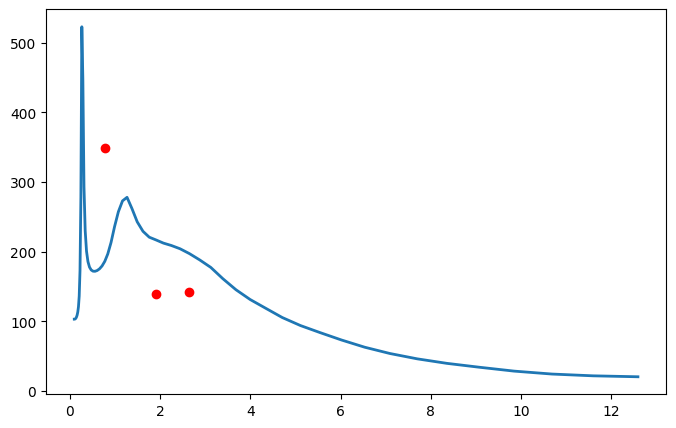

In [ ]:
E_peaks_exp = [0.502, 1.589, 2.941] #Position of the experimental peaks in meV

DELTA=[]

for j in range(len(peaks_results)):
    delta=0
    for i in range(len(E_peaks_exp)):
       delta+=(E_peaks_exp[i]-peaks_results[j]['energies'][i] )**2
    DELTA.append(delta) 

print(DELTA)

best_index = np.argmin(DELTA)
best_result = peaks_results[best_index]

print(f"\nSigma migliore: {best_result['sigma']:.3f}")
print(f"Delta minimo: {DELTA[best_index]:.6f}")
print("Energie simulate:", best_result['energies'])



best_sigma = peaks_results[best_index]['sigma']
best_cross_section = CROSS[best_index]  # è un array 1D di stessa lunghezza di Evec

# Plot
plt.figure(figsize=(8,5))
plt.plot(Evec, best_cross_section, label=f"σ = {best_sigma:.3f}", linewidth=2)
plt.scatter(peaks_results[best_index]['energies'], peaks_results[best_index]['cross_sections'],
            color='red', zorder=5, label='Picchi simulati')
